# Running the nonadiabatic molecular dynamics (NA-MD)

In this tutorial, we conduct NBRA NA-MD calculations using the Libra code. This version implements the generic dynamical approach that is common to model-based NA-MD simulations and the one based on reading files. In this particular case, we setup the interface to pre-computed energy and time-overlap files (as could be produced by any codes) and use it in the generic dynamical workflow.

## Table of contents
<a name="toc"></a>
1. [Importing needed libraries](#import)
2. [Computing the nonadiabatic couplings](#2)\
   2.1. [Kohn-Sham basis](#21)\
   2.2. [Excited state basis](#22)\
   2.3. [Read the files in a selected basis](#23)
3. [Define the interface](#3)
4. [Define parameters and run the calculations](#4) 
5. [Plot results](#5)\
   5.1. [NAMD results](#namd_res)


### A. Learning objectives

* To compute the time-overlaps and nonadiabatic couplings in KS and excited states bases
* To set up and run file-based NBRA NA-MD calculations
* To be able to plot and analyze NAMD results

### B. Use cases

* [Define adiabatic file-based model Hamiltonian](#use_case-3)
* [Compute nonadiabatic dynamics for atomistic systems with NBRA using Kohn-Sham states](#use_case-4)
* [Plotting the results](#5)

### C. Functions

- `libra_py`
  - `dynamics`
    - `tsh`
      - `compute`
        - [`generic_recipe`](#generic_recipe-1)
      - `plot`
        - [`plot_dynamics`](#plot_dynamics-1)
  - `data_conv`
    - [`nparray2CMATRIX`](#nparray2CMATRIX-1)
  - `workflows`
    - `nbra`
      - [`step3`](#comp_nacs)
        - [`run_step3_ks_nacs_libint`](#KS)
        - [`run_step3_sd_nacs_libint`](#excited_states)
  - `units`
    - `au2ev`
    

## 1. Importing needed libraries <a name="1"></a>
[Back to TOC](#toc)

First, let's import all necessary libraries and define parameters such as colors

In [15]:
import os
import matplotlib.pyplot as plt   # plots
import numpy as np
import scipy.sparse as sp
from scipy.optimize import curve_fit
import glob
import h5py
import warnings

from liblibra_core import *
import util.libutil as comn
import libra_py.packages.cp2k.methods as CP2K_methods
from libra_py import units
from libra_py import data_conv
from libra_py import dynamics_plotting
import libra_py.dynamics.tsh.compute as tsh_dynamics
import libra_py.dynamics.tsh.plot as tsh_dynamics_plot
import libra_py.data_savers as data_savers
from libra_py.workflows.nbra import step3

#from matplotlib.mlab import griddata
#%matplotlib inline 
warnings.filterwarnings('ignore')

colors = {}
colors.update({"11": "#8b1a0e"})  # red       
colors.update({"12": "#FF4500"})  # orangered 
colors.update({"13": "#B22222"})  # firebrick 
colors.update({"14": "#DC143C"})  # crimson   
colors.update({"21": "#5e9c36"})  # green
colors.update({"22": "#006400"})  # darkgreen  
colors.update({"23": "#228B22"})  # forestgreen
colors.update({"24": "#808000"})  # olive      
colors.update({"31": "#8A2BE2"})  # blueviolet
colors.update({"32": "#00008B"})  # darkblue  
colors.update({"41": "#2F4F4F"})  # darkslategray

clrs_index = ["11", "21", "31", "41", "12", "22", "32", "13","23", "14", "24"]


## 2. Computing the nonadiabatic couplings <a name="2"></a>
[Back to TOC](#toc)

We are going to need the following files:

* `data/res`

which the folder `res` contains the MO overlap and energy files.

* `data/all_logfiles`

All of the logfiles obtained from the electronic structure calculations of CP2K are stored in this folder. These files will be needed to find the Kohn-Sham HOMO index and also extract the the TD-DFT data for each step.

The above data are also re-packed in the `data.tar.bz2` archive. You can upack it like this:

In [2]:
! tar -xjf data.tar.bz2

### 2.1. Kohn-Sham basis <a name="21"></a>
[Back to TOC](#toc)

The `libra_py.workflow.nbra.step3.run_step3_ks_nacs_libint(params)` computes the NACs between pairs of Kohn-Sham states using the molecular orbital overlaps. 

Libra stores the overlap data in 2-spinor format as follows:

<div>
<img src="./active_space_0.png" width="500"/>
</div>

With no spin-orbit couplings, two blocks of the matrix is zero. Since most of the elements of the overlap matrices are zero, we use the `scipy.sparse` library for storing and loading them. 

The paramters for this function are as follows:

`params['lowest_orbital']`: The lowest orbital considered in the computation of the MO overlaps. This value is exactly the same
as in the `run_template.py` file in step2.

`params['highest_orbital']`: The highest orbital considered in the computation of the MO overlaps. This value is exactly the same
as in the `run_template.py` file in step2.

`params['num_occ_states']`: The number of occupied orbitals to be considered from HOMO to lower occupied states. This value is defined by user.

`params['num_unocc_states']`: The number of unoccupied orbitals to be considered from LUMO to higher unoccupied states. This value is defined by user.

The two values above are used to create an active space which then will be used to select the elements from the MO overlap and 
energy matrices. 

`params['use_multiprocessing']`: A boolean flag to use the multiprocessing library of Python or not.

`params['nprocs']`: The number of processors to be used for the calculations. Libra will use this only if the `params['use_multiprocessing']` 
is set to `True`.

`params['time_step']`: The time-step used in the calculations in `fs`.

`params['es_software']`: The name of the software package used to compute the electronic structure calculations. This will be used to generate the HOMO 
index of that system so it can build the active space.

`params['path_to_npz_files']`: The full path to the MO overlap files.

`params['logfile_directory']`: The full path to the folder where all the log files are stored.

`params['path_to_save_ks_Hvibs']`: The full path to the folder in which the NACs between the Konh-Sham states are stored.

`params['start_time']`: The start time-step.

`params['finish_time']`: The finish time-step.


After setting all the above paramters, the calculations are run using `step3.run_step3_ks_nacs_libint(params)`.

In [3]:
params_ks = {
              'lowest_orbital': 24-10, 'highest_orbital': 24+11, 'num_occ_states': 10, 'num_unocc_states': 10,
              'use_multiprocessing': True, 'nprocs': 12, 'time_step': 1.0, 'es_software': 'cp2k',
              'path_to_npz_files': 'data/res',
              'logfile_directory': 'data/all_logfiles',
              'path_to_save_ks_Hvibs': 'res-ks-DFT',
              'start_time': 1200, 'finish_time': 1401,
            }

step3.run_step3_ks_nacs_libint(params_ks)

Computing orthonormalization of St matrices in stepComputing orthonormalization of St matrices in stepComputing orthonormalization of St matrices in stepComputing orthonormalization of St matrices in stepComputing orthonormalization of St matrices in stepComputing orthonormalization of St matrices in stepComputing orthonormalization of St matrices in stepComputing orthonormalization of St matrices in stepComputing orthonormalization of St matrices in stepComputing orthonormalization of St matrices in step Computing orthonormalization of St matrices in step Computing orthonormalization of St matrices in step     1205  1225 124512201235
 123012151200
1210 

12551240






1250
Done with step 1215 . Elapsed time: 1.905182123184204
Computing orthonormalization of St matrices in step 1216
Done with step 1205Done with step  Done with stepDone with step. Elapsed time:1225    12551230  . Elapsed time:2.24576997756958. Elapsed time:. Elapsed time:
Computing orthonormalization of St matrices in 

Computing orthonormalization of St matrices in step2.633453130722046
Computing orthonormalization of St matrices in step  1291 1296. Elapsed time:
 2.1212494373321533
Done with stepDone with step 
 1300Computing orthonormalization of St matrices in step 1305  . Elapsed time:1311. Elapsed time: 2.579458475112915
 2.882061243057251

Computing orthonormalization of St matrices in stepComputing orthonormalization of St matrices in step Done with step  13011306
1315 . Elapsed time: 2.4379830360412598

Computing orthonormalization of St matrices in step 1316
Done with step 1261 . Elapsed time: 2.4663913249969482
Computing orthonormalization of St matrices in step 1262Done with step 1266 . Elapsed time: 2.5066404342651367
Computing orthonormalization of St matrices in step 1267

Done with stepDone with step  Done with step12811271   1276. Elapsed time:. Elapsed time:   2.30316042900085452.750373601913452
Computing orthonormalization of St matrices in step
 1272. Elapsed time: 
2.4002075195312

1361 . Elapsed time:1346 2.7676031589508057Computing orthonormalization of St matrices in step
Done with step   Computing orthonormalization of St matrices in step. Elapsed time: 1362
1356 1367 2.97991681098938. Elapsed time:

Computing orthonormalization of St matrices in step 1347
Done with step 1327 . Elapsed time: 2.323467493057251
Computing orthonormalization of St matrices in step 1328
 2.8453142642974854
Computing orthonormalization of St matrices in step 1357
Done with step 1376Done with step . Elapsed time: 2.6713242530822754
 1322Computing orthonormalization of St matrices in step . Elapsed time: 2.371760368347168 
1377Computing orthonormalization of St matrices in step
 1323
Done with step 1352 . Elapsed time: 2.1282851696014404
Computing orthonormalization of St matrices in step 1353
Done with step 1332 . Elapsed time: 2.3009557723999023
Computing orthonormalization of St matrices in step 1333
Done with step Done with step1342  1337 . Elapsed time: 2.7522387504577637
. Elap

### 2.2. Excited states basis <a name="22"></a>
[Back to TOC](#toc)

Below, we will be using `step3.run_step3_sd_nacs_libint` function to compute the time-overlaps and nonadiabatic couplings between excited states basis. This can be done either in the many-body or single-particle basis. A schematic of the workflow for selecting new active space is shown below:


Some parameters are common with the ones used to run `step3.run_step3_ks_nacs_libint(params)` above.

Other parameters needed to run the `step3.run_step3_sd_nacs_libint(params)` function are as follows:

`params['isUKS']`: A boolean flag for unrestricted spin calculations.

`params['is_many_body']`: If set to `True`, the NACs will be computed between pairs of many-body (TD-DFT) states. Also, the NACs between single-particle 
SDs obtained from the TD-DFT results will be computed as well. Otherwise, only single-particle NACs will be computed only for the SDs obtained from
`num_occ_states` and `num_unocc_states`. This will be used for xTB calculations in which no TD-DFT is performed.

`params['number_of_states']`: The number of TD-DFT states to consider. This value should not exceed the number of requested TD-DFT states in the CP2K
calculations.

`params['tolerance']`: A lower bound for selection of the excitation with configuration interaction coefficients higher than this value.

`params['verbosity']`: An integer value showing the printing level. The default is set to 0. Higher values will print more data on the terminal.

`params['sorting_type']`: After defining the SDs, Libra will sort them either based on `'energy'` or `'identity'`.


The NACs can also be computed between excited states. These include the single-particle and many-body bases which the latter is obtained from the
TD-DFT calculations. First, we need to compute the overlap between excited state Slater-determinants (SDs) then they will be used to compute the NACs
between them. For many-body states, the configuration interaction coefficietns will also be used. We will consider both single-particle 
and many-body for DFT calculations but only single-particle for xTB.

There are different ways of defining the excited states SDs (the single-particle excited state basis). The first is through 
defining the `num_occ_states` and `num_unocc_states` in which Libra
will start making the SDs from all of the occupied states (starting from `HOMO-num_occ_states+1`) to all of the unoccupied states (ends
to `LUMO+num_unocc_states-1`). Also, if the unrestricted spin calculation flag is set to `True`, the SDs will be made for both alpha and beta spin channels. 

For example, if you want to build the electron-only excitation basis, you need to set `params['num_occ_states'] = 1` and set `params['num_unocc_states']`
to a value less than the number of unoccupied orbitals that was considered in the computation of overlaps. This will generate all the electron-only
excitation from HOMO to unoccupied states.

If the TD-DFT calculations has been done, then Libra will go over all log files and 
generate all the SDs used for all the steps and therefore the definition of these SDs is automatic and Libra will replace the `num_occ_states` and
`num_unocc_states` itself based on the SDs that were generated from the TD-DFT log files. 




In [4]:
params_mb_sd = {
          'lowest_orbital': 24-10, 'highest_orbital': 24+11, 'num_occ_states': 10, 'num_unocc_states': 10,
          'isUKS': 0, 'number_of_states': 10, 'tolerance': 0.01, 'verbosity': 0, 'use_multiprocessing': True, 'nprocs': 12,
          'is_many_body': True, 'time_step': 1.0, 'es_software': 'cp2k',
          'path_to_npz_files': 'data/res',
          'logfile_directory': 'data/all_logfiles',
          'path_to_save_sd_Hvibs': 'res-mb-sd-DFT',
          'outdir': 'res-mb-sd-DFT', 'start_time': 1200, 'finish_time': 1401, 'sorting_type': 'identity',
         }

step3.run_step3_sd_nacs_libint(params_mb_sd)

sd_unique_basis is: [[[24, 25], 'alp'], [[24, 26], 'alp'], [[23, 25], 'alp'], [[22, 25], 'alp'], [[21, 25], 'alp'], [[23, 26], 'alp'], [[22, 26], 'alp'], [[24, 27], 'alp'], [[24, 29], 'alp'], [[21, 26], 'alp'], [[20, 25], 'alp'], [[24, 28], 'alp'], [[20, 26], 'alp'], [[21, 30], 'alp'], [[19, 26], 'alp'], [[19, 25], 'alp'], [[20, 27], 'alp'], [[23, 27], 'alp'], [[23, 28], 'alp'], [[24, 30], 'alp']]
sd_states_reindexed is: [[1, -1, 2, -2, 3, -3, 4, -4, 5, -5, 6, -6], [1, -1, 2, -2, 3, -3, 4, -4, 5, -5, 7, -6], [1, -1, 2, -2, 3, -3, 4, -4, 5, -5, 8, -6], [1, -1, 2, -2, 3, -3, 4, -4, 7, -5, 6, -6], [1, -1, 2, -2, 3, -3, 7, -4, 5, -5, 6, -6], [1, -1, 2, -2, 7, -3, 4, -4, 5, -5, 6, -6], [1, -1, 2, -2, 3, -3, 4, -4, 8, -5, 6, -6], [1, -1, 2, -2, 3, -3, 8, -4, 5, -5, 6, -6], [1, -1, 2, -2, 3, -3, 4, -4, 5, -5, 9, -6], [1, -1, 2, -2, 3, -3, 4, -4, 5, -5, 11, -6], [1, -1, 2, -2, 8, -3, 4, -4, 5, -5, 6, -6], [1, -1, 7, -2, 3, -3, 4, -4, 5, -5, 6, -6], [1, -1, 2, -2, 3, -3, 4, -4, 5, -5, 10, -6], 

Computing the SD overlaps for stepComputing the SD overlaps for step65Done with computing the SD overlap of step 34. Elapsed time 0.02925419807434082 

Done with computing the SD overlap of step 54. Elapsed time 0.02963113784790039
Computing the SD overlaps for step 7060Computing the SD overlaps for step
Done with computing the SD overlap of step 19. Elapsed time 0.029020071029663086  Computing the SD overlaps for step

80 85

Computing the SD overlaps for stepDone with computing the SD overlap of step 24. Elapsed time 0.03115558624267578

75Computing the SD overlaps for step
 Computing the SD overlaps for step95 
90
 100
Computing the SD overlaps for stepDone with computing the SD overlap of step 14. Elapsed time 0.029762983322143555 
105

Computing the SD overlaps for step 110
Done with computing the SD overlap of step 29. Elapsed time 0.029046058654785156Done with computing the SD overlap of step 65. Elapsed time 0.028792381286621094

Computing the SD overlaps for stepDone with comp

Computing the SD overlaps for stepComputing the SD overlaps for step Done with computing the SD overlap of step 145. Elapsed time 0.029109954833984375126Done with computing the SD overlap of step 135. Elapsed time 0.02929401397705078

Done with computing the SD overlap of step 130. Elapsed time 0.02895951271057129 
175
Computing the SD overlaps for step
 Done with computing the SD overlap of step 155. Elapsed time 0.02959585189819336131Computing the SD overlaps for stepDone with computing the SD overlap of step 150. Elapsed time 0.028947830200195312
 
Computing the SD overlaps for stepDone with computing the SD overlap of step 140. Elapsed time 0.029474973678588867
146 156Computing the SD overlaps for step

 Computing the SD overlaps for step 141
Computing the SD overlaps for step
136 
151
Done with computing the SD overlap of step 165. Elapsed time 0.028911352157592773
Computing the SD overlaps for stepDone with computing the SD overlap of step 170. Elapsed time 0.029144763946533203 1

Computing the SD overlaps for step Done with computing the SD overlap of step 182. Elapsed time 0.03012824058532715
198Computing the SD overlaps for step
 183
Done with computing the SD overlap of step 193. Elapsed time 0.030139446258544922
Computing the SD overlaps for step 194
Done with computing the SD overlap of step 188. Elapsed time 0.04031038284301758
Computing the SD overlaps for step 189
Done with computing the SD overlap of step 183. Elapsed time 0.028076648712158203
Computing the SD overlaps for step 184
Done with computing the SD overlap of step 198. Elapsed time 0.03228616714477539
Computing the SD overlaps for step 199
Done with computing the SD overlap of step 194. Elapsed time 0.026639223098754883
Done with computing the SD overlap of step 189. Elapsed time 0.03329777717590332
Done with computing the SD overlap of step 184. Elapsed time 0.026557207107543945
Done with computing the SD overlap of step 199. Elapsed time 0.0388638973236084
Done with computing the SD overlap

### 2.3. Read the files in a selected basis<a name="23"></a>
[Back to TOC](#toc)

Here, we will be reading the files required for NBRA-NAMD simulations. In this example, we select the MB basis where the overlaps and energies are computed in the `res-mb-sd-DFT` folder. This folder is `params_mb_sd['path_to_save_sd_Hvibs']` in the above cell. The parameters in the cell below are:

`istep`: The initial step which we define as `params_mb_sd['start_time']`.

`fstep`: The final step which is defined as ` params_mb_sd['finish_time']-1`. The reason for subtracting `1` from this variable is that Libra will consider the mid-point energies when constructing the vibronic Hamiltonian. 

`NSTEPS`: Number of steps.

Note that all the files from `istep` to `fstep` should exist. 

In [5]:
istep = params_mb_sd['start_time']
fstep = params_mb_sd['finish_time']-2
NSTEPS = fstep - istep
#================== Read energies =====================
E = []
for step in range(istep,fstep):
    energy_filename = F"{params_mb_sd['path_to_save_sd_Hvibs']}/Hvib_ci_{step}_re.npz"
    energy_mat = sp.load_npz(energy_filename)
    # For data conversion we need to turn np.ndarray to np.array so that 
    # we can use data_conv.nparray2CMATRIX
    E.append( np.array( np.diag( energy_mat.todense() ) ) )
E = np.array(E)
NSTATES = E[0].shape[0]
#================== Read time-overlap =====================
St = []
for step in range(istep,fstep):        
    St_filename = F"{params_mb_sd['path_to_save_sd_Hvibs']}/St_ci_{step}_re.npz"
    St_mat = sp.load_npz(St_filename)
    St.append( np.array( St_mat.todense() ) )
St = np.array(St)
#================ Compute NACs and vibronic Hamiltonians along the trajectory ============    
NAC = []
Hvib = [] 
for c, step in enumerate(range(istep,fstep)):
    nac_filename = F"{params_mb_sd['path_to_save_sd_Hvibs']}/Hvib_ci_{step}_im.npz"
    nac_mat = sp.load_npz(nac_filename)
    NAC.append( np.array( nac_mat.todense() ) )
    Hvib.append( np.diag(E[c, :])*(1.0+1j*0.0)  - (0.0+1j)*nac_mat[:, :] )

NAC = np.array(NAC)
Hvib = np.array(Hvib)

print('Number of steps:', NSTEPS)
print('Number of states:', NSTATES)

Number of steps: 199
Number of states: 11


In [6]:
print(NAC.shape)
print(Hvib.shape)
print(St.shape)

(199, 11, 11)
(199, 11, 11)
(199, 11, 11)


## 3. Define the interface <a name="3"></a>
[Back to TOC](#toc)

The interface function should be defined as explained in other tutorials. It should return objects with the specifically-named data members. This is what we defined here:
<a name="nparray2CMATRIX-1"></a><a name="use_case-3"></a>

In [7]:
class tmp:
    pass

def compute_model(q, params, full_id):
    timestep = params["timestep"]
    nst = params["nstates"]
    obj = tmp()

    obj.ham_adi = data_conv.nparray2CMATRIX( np.diag(E[timestep, : ]) )
    obj.nac_adi = data_conv.nparray2CMATRIX( NAC[timestep, :, :] )
    obj.hvib_adi = data_conv.nparray2CMATRIX( Hvib[timestep, :, :] )
    obj.basis_transform = CMATRIX(nst,nst); obj.basis_transform.identity()  #basis_transform
    obj.time_overlap_adi = data_conv.nparray2CMATRIX( St[timestep, :, :] )
    
    return obj


## 4. Define parameters and run the calculations <a name="4"></a>
[Back to TOC](#toc)

Make sure you define all of these 4 parameters of the `model_params` dictionary. Here, we first initialize the parameter `timestep` to `0`. This parameter will be updated to `icond` which is representative of the initial geomtery. 

In [8]:
#================== Model parameters ====================
model_params = { "timestep":0, "icond":10,  "model0":0, "nstates":NSTATES }

Dynamics control parameters are as follows:

`nfiles`: The total number of files that was read.

`nsteps`: The total number of steps for dynamics. Note that this number can be larger than the number of files `nfiles` read. For `nsteps` more than `nfiles`, Libra will repeat the Hamiltonian matrices and do the dynamics.

`ntraj`: The number of surface hopping trajectories.

`dt`: The time step in atomic units.

`decoherence_rates`: The matrix of dephasing rates with a unit of a.u. of time$^{-1}$.

`ave_gaps`: A matrix that contains the averaged moduli of the energy gaps

$$E_{ij}= |E_i - E_j|$$

It is needed when `dephasing_informed` option is used.

`progress_frequency`: At what intervals print out some "progress" messages. For instance, if you have `nsteps = 100` and `progress_frequency = 0.1`, the code will notify you every 10 steps.

`which_adi_states`: Indices of the adiabatic states to plot.

`which_dia_states`: Indices of the diabatic states to plot.

`mem_output_level`: Controls what info to save into HDF5 files (all at the end) Same meaning and output as with `hdf5_output_level`, except all the variables are first stored in memory (while the calcs are running) and then they are written into the HDF5 file at the end of the calculations. This is a much faster version of hdf5 saver.

`properties_to_save`: Describes what properties to save to the HDF5 files. Note that if some properties are not listed in this variable, then they are not saved, even if `mem_output_level` suggests they may be saved. You need to BOTH set the appropriate `mem_output_level` AND `properties_to_save`:

```
default:  [ "timestep", "time", "Ekin_ave", "Epot_ave", "Etot_ave", 
         "dEkin_ave", "dEpot_ave", "dEtot_ave", "states", "SH_pop", "SH_pop_raw",
         "D_adi", "D_adi_raw", "D_dia", "D_dia_raw", "q", "p", "Cadi", "Cdia", 
         "hvib_adi", "hvib_dia", "St", "basis_transform", "projector"]
```

`prefix`: The name of the folder to be created by this function. All the data files will be created in that folder.

`isNBRA`: A flag for NBRA type of calculations.

Other parameters for NBRA-specific parameters are explained in the comments of the cell below.

In [9]:
#=============== Some automatic variables, related to the settings above ===================

dyn_general = { "nsteps":NSTEPS*2, "ntraj":25, "nstates":NSTATES, "dt":1.0*units.fs2au, "nfiles": NSTEPS,
                "decoherence_rates":MATRIX(NSTATES,NSTATES), "ave_gaps":MATRIX(NSTATES,NSTATES),                
                "progress_frequency":0.1, "which_adi_states":range(NSTATES), "which_dia_states":range(NSTATES),
                "mem_output_level":2,
                "properties_to_save":[ "timestep", "time","se_pop_adi", "sh_pop_adi" ],
                "prefix":F"NBRA", "isNBRA":0
              }

#=========== Some NBRA-specific parameters - these are the key settings for running file-based NBRA calculations ===========

dyn_general.update({"ham_update_method":2})  # read adiabatic properties from mthe files

dyn_general.update({"ham_transform_method":0})  # don't attempt to compute adiabatic properties from the diabatic ones, not to
                                                # override the read ones 
    
dyn_general.update({"time_overlap_method":0})  # don't attempt to compute those, not to override the read ones

dyn_general.update({"nac_update_method":0})    # don't attempt to recompute NACs, so that we don't override the read values

dyn_general.update({"hvib_update_method":0})   # don't attempt to recompute Hvib, so that we don't override the read values


dyn_general.update( {"force_method":0, "rep_force":1} ) # NBRA = don't compute forces, so rep_force actually doesn't matter


dyn_general.update({"hop_acceptance_algo":32, "momenta_rescaling_algo":0 })  # accept based on Boltzmann, no velocity rescaling

dyn_general.update( {"rep_tdse":1}) # the TDSE integration is conducted in adiabatic rep

dyn_general.update( {"electronic_integrator":2} )  # using the local diabatization approach to integrate TD-SE



#============ Surface hopping opntions =================
dyn_general.update({"tsh_method":0 }) # FSSH
dyn_general.update({ "decoherence_algo":-1}) # no (additional) decoherence
dyn_general.update({"decoherence_times_type":-1 }) # No decoherence times, infinite decoherence times
dyn_general.update({"do_ssy":0 }) # do no use Shenvi-Subotnik-Yang phase correction
dyn_general.update( {"dephasing_informed":0} ) # no dephasing-informed correction


Now, we define the nuclear and electronic parameters. The nuclear parameters do not matter in the NBRA-NAMD. The initial state is defined in the `elec_params` with the `istate` parameter. `rep` shows in which representation the dynamics should be done where `1` is the adiabatic representation and `0` shows the dynamics in diabatic representation.

Other parameters in the `elec_params` are used for density matrix and amplitudes initialization.

[Back to TOC](#toc)

In [10]:
#=================== Dynamics =======================
# Nuclear DOF - these parameters don't matter much in the NBRA calculations
nucl_params = {"ndof":1, "init_type":3, "q":[-10.0], "p":[0.0], "mass":[2000.0], "force_constant":[0.01], "verbosity":-1 }

# Amplitudes are sampled
elec_params = {"ndia":NSTATES, "nadi":NSTATES, "verbosity":-1, "init_dm_type":0}


elec_params.update( {"init_type":1,  "rep":1,  "istate":10 } )  # how to initialize: random phase, adiabatic representation, given initial state

Finally run the calculations for initial conditions in `range(0,200,20)`.
<a name="generic_recipe-1"></a><a name="use_case-4"></a>

In [11]:
rnd = Random()

for icond in range(0,NSTEPS,20):
    print('Running the calculations for icond:', icond)
    model_params.update({"icond": icond})
    dyn_general.update({"prefix":F"NBRA_icond_{icond}"})
    res = tsh_dynamics.generic_recipe(dyn_general, compute_model, model_params, elec_params, nucl_params, rnd)

Running the calculations for icond: 0
 step= 39
 step= 78
 step= 117
 step= 156
 step= 195
 step= 234
 step= 273
 step= 312
 step= 351
 step= 390
In mem_saver.save_data()
data_name =  ['timestep', 'time', 'se_pop_adi', 'sh_pop_adi']
keywords =  ['timestep', 'time', 'se_pop_adi', 'sh_pop_adi']
keys =  dict_keys(['timestep', 'time', 'se_pop_adi', 'sh_pop_adi'])
Saving the dataset named timestep/data
Saving the dataset named time/data
Saving the dataset named se_pop_adi/data
Saving the dataset named sh_pop_adi/data
Running the calculations for icond: 20
t parametersUse the default value 
In cctor: lvl = 1 der_lvl = 2


 step= 39
 step= 78
 step= 117
 step= 156
 step= 195
 step= 234
 step= 273
 step= 312
 step= 351
 step= 390
In mem_saver.save_data()
data_name =  ['timestep', 'time', 'se_pop_adi', 'sh_pop_adi']
keywords =  ['timestep', 'time', 'se_pop_adi', 'sh_pop_adi']
keys =  dict_keys(['timestep', 'time', 'se_pop_adi', 'sh_pop_adi'])
Saving the dataset named timestep/data
Saving the dataset named time/data
Saving the dataset named se_pop_adi/data
Saving the dataset named sh_pop_adi/data
Running the calculations for icond: 40
efined! in the input parametersUse the default value 
In cctor: lvl = 1 der_lvl = 2
 step= 39
 step= 78
 step= 117
 step= 156
 step= 195
 step= 234
 step= 273
 step= 312
 step= 351
 step= 390
In mem_saver.save_data()
data_name =  ['timestep', 'time', 'se_pop_adi', 'sh_pop_adi']
keywords =  ['timestep', 'time', 'se_pop_adi', 'sh_pop_adi']
keys =  dict_keys(['timestep', 'time', 'se_pop_adi', 'sh_pop_adi'])
Saving the dataset named timestep/data
Saving the dataset named time/data

 step= 39
 step= 78
 step= 117
 step= 156
 step= 195
 step= 234
 step= 273
 step= 312
 step= 351
 step= 390
In mem_saver.save_data()
data_name =  ['timestep', 'time', 'se_pop_adi', 'sh_pop_adi']
keywords =  ['timestep', 'time', 'se_pop_adi', 'sh_pop_adi']
keys =  dict_keys(['timestep', 'time', 'se_pop_adi', 'sh_pop_adi'])
Saving the dataset named timestep/data
Saving the dataset named time/data
Saving the dataset named se_pop_adi/data
Saving the dataset named sh_pop_adi/data
Running the calculations for icond: 80
ARNING: Parameter Temperature is not defined! in the input parametersUse the default value 
In cctor: lvl = 1 der_lvl = 2
 step= 39
 step= 78
 step= 117
 step= 156
 step= 195
 step= 234
 step= 273
 step= 312
 step= 351
 step= 390
In mem_saver.save_data()
data_name =  ['timestep', 'time', 'se_pop_adi', 'sh_pop_adi']
keywords =  ['timestep', 'time', 'se_pop_adi', 'sh_pop_adi']
keys =  dict_keys(['timestep', 'time', 'se_pop_adi', 'sh_pop_adi'])
Saving the dataset named timestep/d

 step= 39
 step= 78
 step= 117
 step= 156
 step= 195
 step= 234
 step= 273
 step= 312
 step= 351
 step= 390
In mem_saver.save_data()
data_name =  ['timestep', 'time', 'se_pop_adi', 'sh_pop_adi']
keywords =  ['timestep', 'time', 'se_pop_adi', 'sh_pop_adi']
keys =  dict_keys(['timestep', 'time', 'se_pop_adi', 'sh_pop_adi'])
Saving the dataset named timestep/data
Saving the dataset named time/data
Saving the dataset named se_pop_adi/data
Saving the dataset named sh_pop_adi/data
Running the calculations for icond: 120
put parametersUse the default value 
In cctor: lvl = 1 der_lvl = 2
 step= 39
 step= 78
 step= 117
 step= 156
 step= 195
 step= 234
 step= 273
 step= 312
 step= 351
 step= 390
In mem_saver.save_data()
data_name =  ['timestep', 'time', 'se_pop_adi', 'sh_pop_adi']
keywords =  ['timestep', 'time', 'se_pop_adi', 'sh_pop_adi']
keys =  dict_keys(['timestep', 'time', 'se_pop_adi', 'sh_pop_adi'])
Saving the dataset named timestep/data
Saving the dataset named time/data
Saving the data

 step= 39
 step= 78
 step= 117
 step= 156
 step= 195
 step= 234
 step= 273
 step= 312
 step= 351
 step= 390
In mem_saver.save_data()
data_name =  ['timestep', 'time', 'se_pop_adi', 'sh_pop_adi']
keywords =  ['timestep', 'time', 'se_pop_adi', 'sh_pop_adi']
keys =  dict_keys(['timestep', 'time', 'se_pop_adi', 'sh_pop_adi'])
Saving the dataset named timestep/data
Saving the dataset named time/data
Saving the dataset named se_pop_adi/data
Saving the dataset named sh_pop_adi/data
Running the calculations for icond: 160
r ETHD3_beta is not defined! in the input parametersUse the default value 
In cctor: lvl = 1 der_lvl = 2
 step= 39
 step= 78
 step= 117
 step= 156
 step= 195
 step= 234
 step= 273
 step= 312
 step= 351
 step= 390
In mem_saver.save_data()
data_name =  ['timestep', 'time', 'se_pop_adi', 'sh_pop_adi']
keywords =  ['timestep', 'time', 'se_pop_adi', 'sh_pop_adi']
keys =  dict_keys(['timestep', 'time', 'se_pop_adi', 'sh_pop_adi'])
Saving the dataset named timestep/data
Saving the d

 step= 39
 step= 78
 step= 117
 step= 156
 step= 195
 step= 234
 step= 273
 step= 312
 step= 351
 step= 390
In mem_saver.save_data()
data_name =  ['timestep', 'time', 'se_pop_adi', 'sh_pop_adi']
keywords =  ['timestep', 'time', 'se_pop_adi', 'sh_pop_adi']
keys =  dict_keys(['timestep', 'time', 'se_pop_adi', 'sh_pop_adi'])
Saving the dataset named timestep/data
Saving the dataset named time/data
Saving the dataset named se_pop_adi/data
Saving the dataset named sh_pop_adi/data


## 5. Plot results <a name="5"></a>
[Back to TOC](#toc)

### 5.1. Energy vs time <a name="ene_time"></a>

Here, we will plot the energies of the many-body and single-particle excitation bases

In [13]:
def exp_func(t, tau):
    return np.exp(-np.power(t/tau,2))

tau: [1576.56495827]  R2: 0.5763911944829941


<IPython.core.display.Javascript object>


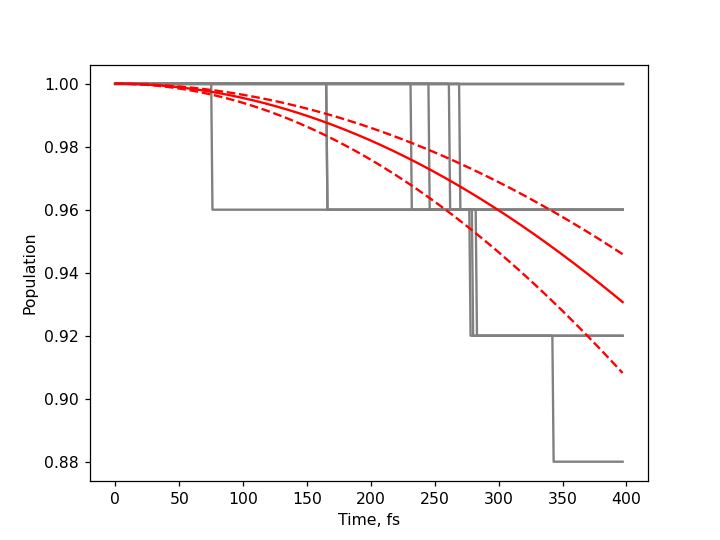

tau: [15499.93419139]  R2: -inf
tau: [1124.5180244]  R2: 0.8577703892461284
tau: [1841.66391553]  R2: 0.7290903075740425
tau: [1172.91729256]  R2: 0.6050354465204799
tau: [15499.93419139]  R2: -inf
tau: [1269.28137813]  R2: 0.8005286919063264
tau: [15499.93419139]  R2: -inf
tau: [1576.56495827]  R2: 0.5763911944829941
tau: [1805.62626029]  R2: 0.7416151511855505
The timescales: 1481.019541065691+-202.0166754930847 fs, averaged over 7 samples


In [16]:
%matplotlib notebook
dt = 1
taus = []
for icond in range(0,199,20):
    F = h5py.File(F'NBRA_icond_{icond}/mem_data.hdf')
    sh_pop = np.array(F['sh_pop_adi/data'])
    F.close()
    md_time = np.arange(0,sh_pop.shape[0])*dt
    pop_recov = 1-np.sum(sh_pop[:,[1,2]], axis=1)
    popt, pcov = curve_fit( exp_func, md_time, pop_recov, bounds=([0.0],[np.inf]))
    tau = popt
    # Computing the R-squared
    residuals  = pop_recov - exp_func(md_time, *popt)
    ss_res     = np.sum(residuals**2)
    ss_tot     = np.sum((pop_recov - np.mean(pop_recov))**2)
    r_squared  = 1.0 - (ss_res / ss_tot)
    print('tau:', tau,  ' R2:', r_squared)

    if r_squared>0.1:
        taus.append(tau)
    plt.plot(md_time, pop_recov, color='gray')
plt.ylabel('Population')
plt.xlabel('Time, fs')

taus = np.array(taus)
ave_tau = np.average(taus)
s = np.std(taus)
Z = 1.96
N = taus.shape[0]
error_bar = Z*s/np.sqrt(N)
print(F'The timescales: {ave_tau}+-{error_bar} fs, averaged over {len(taus)} samples')
plt.plot(md_time, exp_func(md_time, ave_tau-error_bar), ls='--', color='red')
plt.plot(md_time, exp_func(md_time, ave_tau), ls='-',  color='red')
plt.plot(md_time, exp_func(md_time, ave_tau+error_bar), ls='--', color='red')
